# KTM Komuter Feature Engineering

This notebook focuses on feature engineering for our KomuterPulse project, which aims to develop a real-time transit intelligence platform for KTM Komuter operations. We'll analyze the features created during preprocessing, select the most relevant ones, and potentially create new features to improve our models.

## Objectives

1. Analyze feature correlations and relationships
2. Perform feature selection to identify the most important variables
3. Apply dimensionality reduction techniques
4. Evaluate feature importance for our prediction tasks
5. Determine the optimal feature subset for our models

Our primary target variable is hourly ridership between station pairs (regression), with a secondary focus on anomaly detection (binary classification).

## Setup and Data Loading

First, let's import the necessary libraries and load our preprocessed dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from datetime import datetime
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import warnings

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the preprocessed training dataset
DATA_DIR = Path('../data/processed')
train_path = DATA_DIR / 'komuter_train.csv'
test_path = DATA_DIR / 'komuter_test.csv'

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Training data loaded: {train_df.shape}")
    print(f"Testing data loaded: {test_df.shape}")
except FileNotFoundError:
    print("Error: Processed data files not found. Run the preprocessing notebook first.")

# Display the first few rows of the training dataset
train_df.head()

Training data loaded: (537642, 55)
Testing data loaded: (132957, 55)


,route,date,hour,total_ridership,avg_ridership,max_ridership,day_of_week,is_weekend,origin,destination,origin_popularity,destination_popularity,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,total_ridership_lag_1h,total_ridership_lag_2h,total_ridership_lag_3h,total_ridership_lag_6h,total_ridership_lag_12h,total_ridership_lag_24h,total_ridership_lag_1w,rolling_mean_3h,rolling_std_3h,rolling_max_3h,rolling_min_3h,rolling_mean_6h,rolling_std_6h,rolling_max_6h,rolling_min_6h,rolling_mean_12h,rolling_std_12h,rolling_max_12h,rolling_min_12h,rolling_mean_24h,rolling_std_24h,rolling_max_24h,rolling_min_24h,rolling_dow_mean,ridership_diff_1h,ridership_diff_2h,ridership_pct_change_1h,ridership_diff_1d,ridership_pct_change_1d,ridership_diff_1w,ridership_pct_change_1w,hour_of_day,is_rush_hour,is_peak_morning,is_peak_evening,is_business_hours,is_night_hours,is_statistical_outlier,is_route_outlier
0,Abdullah Hukum → Abdullah Hukum,2025-01-03,22,2,2.0,2,4,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,0.866025,-0.433884,-0.900969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,2.947211,2.0,2.0,2.000000,3.723052,2.0,2.0,2.000000,4.406935,2.0,2.0,2.000000,4.704380,2.0,2.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,False,False,False,False,True,False,False
1,Abdullah Hukum → Abdullah Hukum,2025-01-05,14,1,1.0,1,6,True,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,-0.866025,-0.781831,0.623490,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.500000,0.707107,2.0,1.0,1.500000,0.707107,2.0,1.0,1.500000,0.707107,2.0,1.0,1.500000,0.707107,2.0,1.0,1.500000,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,14,False,False,False,False,False,False,False
2,Abdullah Hukum → Abdullah Hukum,2025-01-06,19,2,2.0,2,0,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,0.258819,0.000000,1.000000,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.666667,0.577350,2.0,1.0,1.666667,0.577350,2.0,1.0,1.666667,0.577350,2.0,1.0,1.666667,0.577350,2.0,1.0,1.666667,1.0,0.0,1.0,0.0,0.0,0.0,0.0,19,True,False,True,False,False,False,False
3,Abdullah Hukum → Abdullah Hukum,2025-01-07,16,1,1.0,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.866025,-0.500000,0.781831,0.623490,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.333333,0.577350,2.0,1.0,1.500000,0.577350,2.0,1.0,1.500000,0.577350,2.0,1.0,1.500000,0.577350,2.0,1.0,1.500000,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,16,False,False,False,True,False,False,False
4,Abdullah Hukum → Abdullah Hukum,2025-01-07,19,1,1.0,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,0.258819,0.781831,0.623490,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.333333,0.577350,2.0,1.0,1.400000,0.547723,2.0,1.0,1.400000,0.547723,2.0,1.0,1.400000,0.547723,2.0,1.0,1.400000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,19,True,False,True,False,False,False,False


## Data Overview and Target Definition

Let's take a closer look at our data and define our target variable.

In [8]:
# Get basic information about the training data
print("Training data info:")
train_df.info()

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum().sum())

# Define our target variable and features
target_col = 'total_ridership'  # Primary target for regression
# Secondary target for anomaly detection, already created during preprocessing
anomaly_cols = ['is_statistical_outlier', 'is_route_outlier']

# Identify datetime and categorical columns that we will exclude from modeling
datetime_cols = ['date']
id_cols = ['route', 'origin', 'destination']

# Identify features
categorical_cols = ['day_of_week']
exclude_cols = datetime_cols + id_cols + [target_col] + anomaly_cols
all_feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f"\nNumber of features: {len(all_feature_cols)}")
print(f"Target variable: {target_col}")

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537642 entries, 0 to 537641
Data columns (total 55 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   route                    537642 non-null  object 
 1   date                     537642 non-null  object 
 2   hour                     537642 non-null  int64  
 3   total_ridership          537642 non-null  int64  
 4   avg_ridership            537642 non-null  float64
 5   max_ridership            537642 non-null  int64  
 6   day_of_week              537642 non-null  int64  
 7   is_weekend               537642 non-null  bool   
 8   origin                   537642 non-null  object 
 9   destination              537642 non-null  object 
 10  origin_popularity        537642 non-null  float64
 11  destination_popularity   537642 non-null  float64
 12  hour_sin                 537642 non-null  float64
 13  hour_cos                 537642 non-nul

## Feature Correlation Analysis

Let's analyze correlations between features and our target variable to identify the strongest predictors.

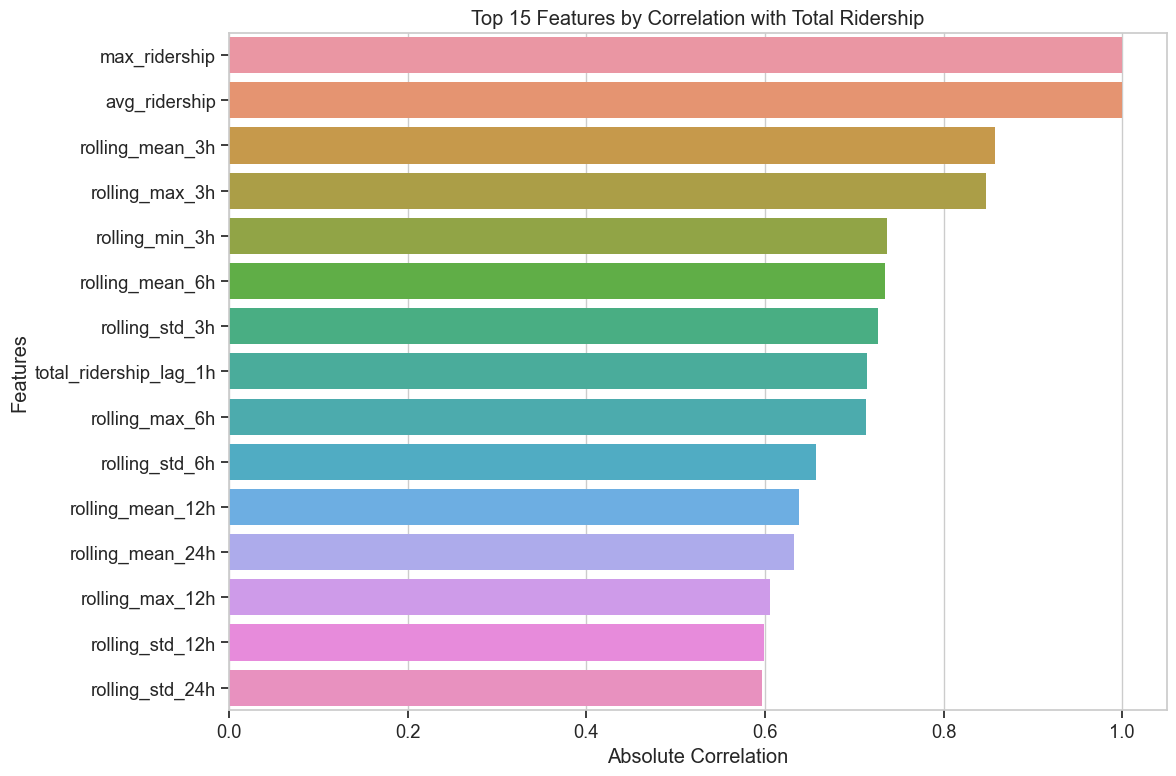

Top 15 correlations with total_ridership:
max_ridership             1.000000
avg_ridership             1.000000
rolling_mean_3h           0.857252
rolling_max_3h            0.847704
rolling_min_3h            0.736695
rolling_mean_6h           0.734731
rolling_std_3h            0.726275
total_ridership_lag_1h    0.714243
rolling_max_6h            0.713540
rolling_std_6h            0.657162
rolling_mean_12h          0.638568
rolling_mean_24h          0.632248
rolling_max_12h           0.605587
rolling_std_12h           0.599216
rolling_std_24h           0.596123
dtype: float64


In [9]:
# Calculate correlations with target variable
numeric_features = train_df[all_feature_cols].select_dtypes(include=['number'])
correlations = numeric_features.corrwith(train_df[target_col])

# Sort correlations and display top 15
sorted_correlations = correlations.abs().sort_values(ascending=False)
top_correlations = sorted_correlations.head(15)

# Plot top 15 feature correlations with target
plt.figure(figsize=(12, 8))
sns.barplot(x=top_correlations.values, y=top_correlations.index)
plt.title('Top 15 Features by Correlation with Total Ridership')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("Top 15 correlations with total_ridership:")
top_correlations_with_sign = correlations[top_correlations.index].sort_values(ascending=False)
print(top_correlations_with_sign)

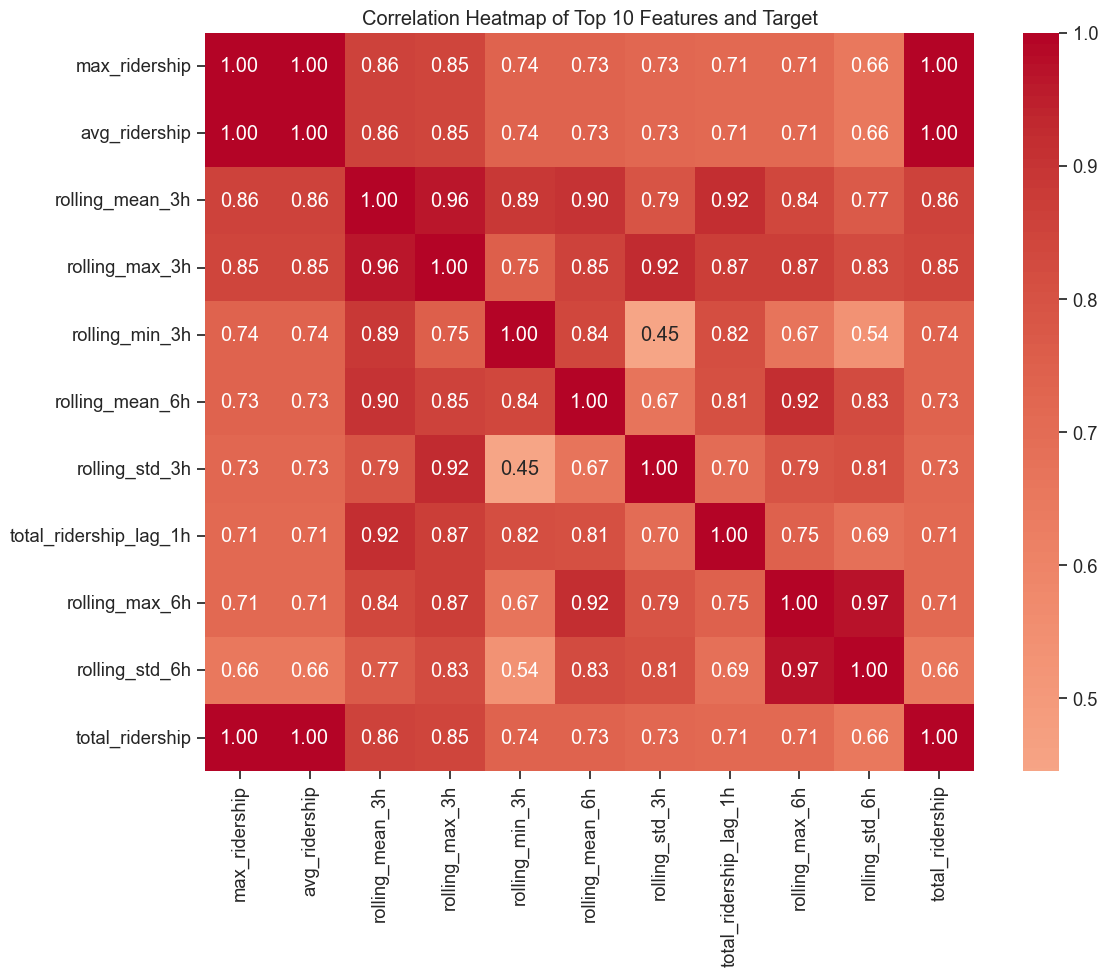

In [10]:
# Create correlation matrix for top features
top_features = top_correlations.index.tolist()[:10]  # Take top 10 for clarity in heatmap
correlation_matrix = train_df[top_features + [target_col]].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Top 10 Features and Target')
plt.tight_layout()
plt.show()

### Multicollinearity Analysis

Check for multicollinearity among the top features to identify redundant predictors.

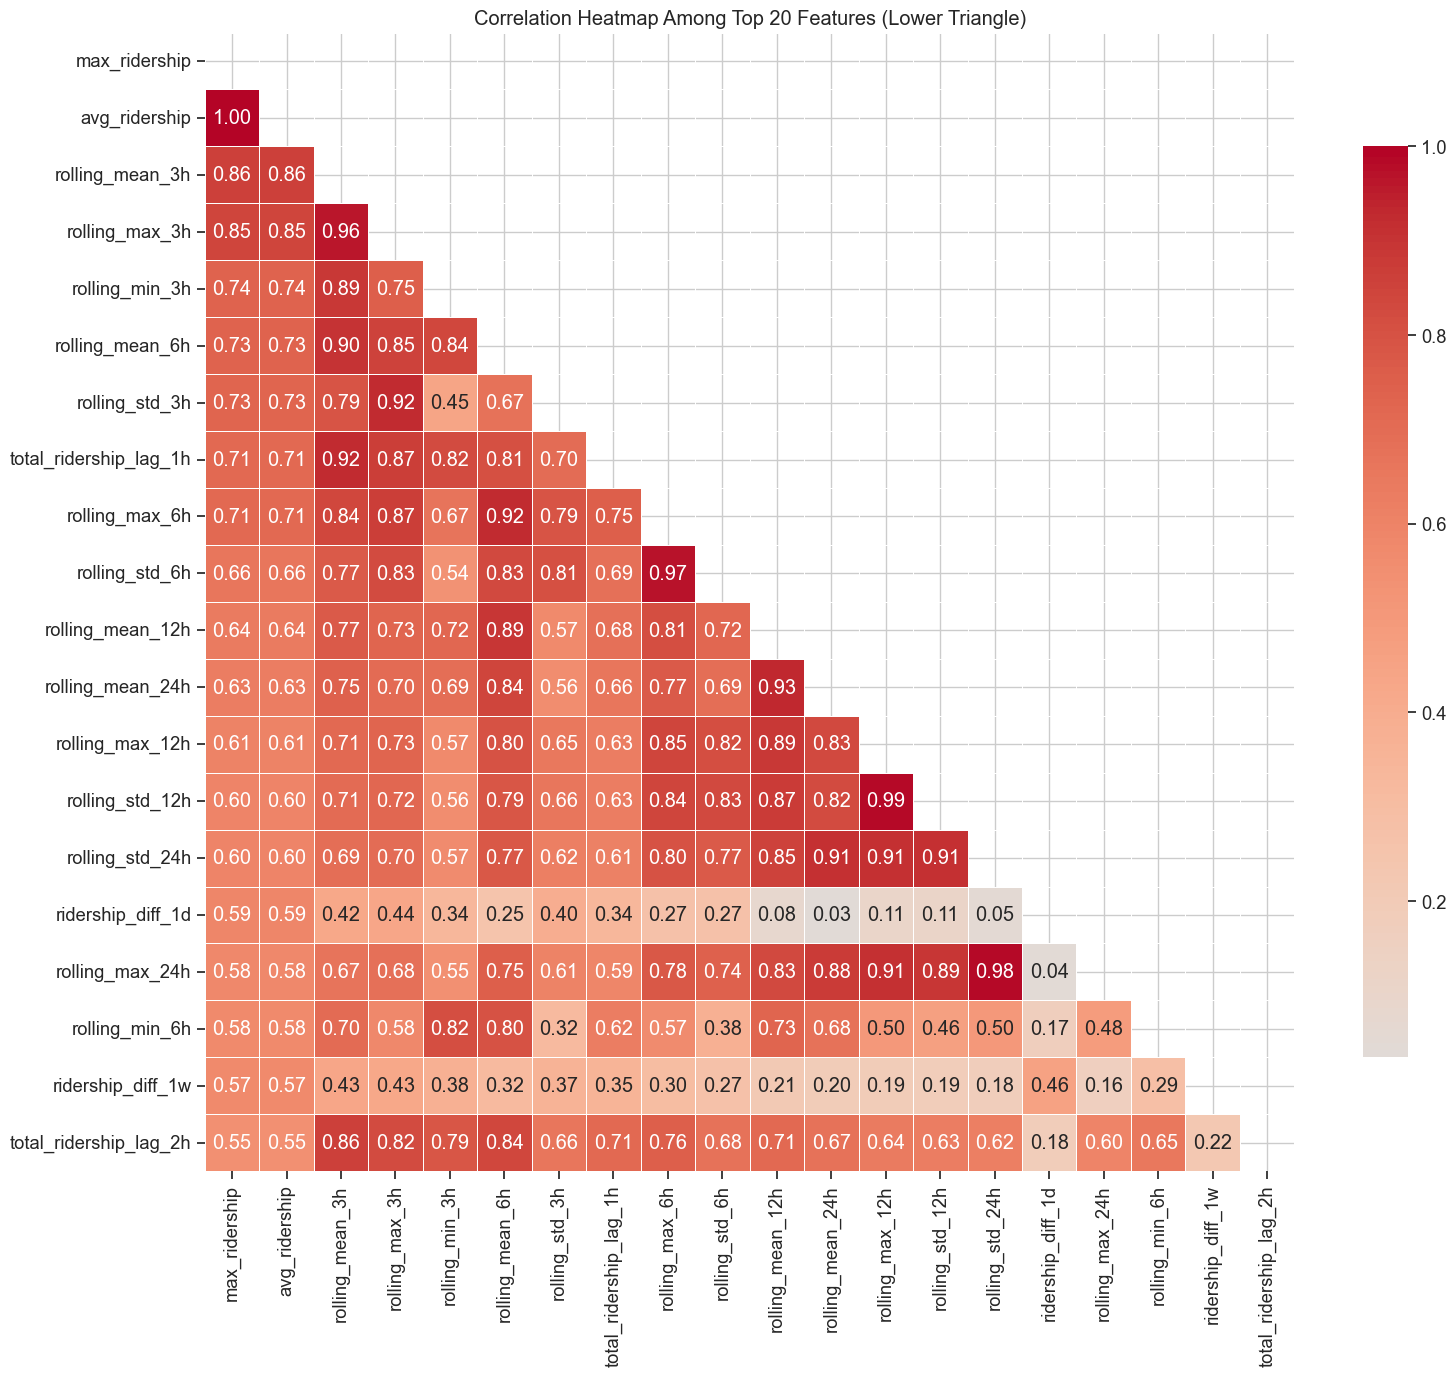


Highly correlated feature pairs (|corr| > 0.8):
                 Feature 1         Feature 2  Correlation
0            avg_ridership     max_ridership     1.000000
34         rolling_std_12h   rolling_max_12h     0.988098
43         rolling_max_24h   rolling_std_24h     0.982872
21          rolling_std_6h    rolling_max_6h     0.972977
5           rolling_max_3h   rolling_mean_3h     0.962453
25        rolling_mean_24h  rolling_mean_12h     0.933955
10          rolling_std_3h    rolling_max_3h     0.923253
17          rolling_max_6h   rolling_mean_6h     0.921734
11  total_ridership_lag_1h   rolling_mean_3h     0.921270
38         rolling_std_24h   rolling_std_12h     0.910837
36         rolling_std_24h  rolling_mean_24h     0.910359
37         rolling_std_24h   rolling_max_12h     0.909325
41         rolling_max_24h   rolling_max_12h     0.906166
7          rolling_mean_6h   rolling_mean_3h     0.901655
22        rolling_mean_12h   rolling_mean_6h     0.893071
42         rolling_max_

In [11]:
# Check for multicollinearity using a heatmap of correlations among top 20 features
top20_features = sorted_correlations.index[:20].tolist()
top20_correlation_matrix = train_df[top20_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(top20_correlation_matrix, dtype=bool))

# Plot heatmap with mask for upper triangle
plt.figure(figsize=(16, 14))
sns.heatmap(top20_correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, linewidths=.5, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap Among Top 20 Features (Lower Triangle)')
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs
print("\nHighly correlated feature pairs (|corr| > 0.8):")

# Create a DataFrame to store correlated pairs
correlated_pairs = []

# Iterate through the correlation matrix
for i in range(len(top20_correlation_matrix.columns)):
    for j in range(i):
        if abs(top20_correlation_matrix.iloc[i, j]) > 0.8:
            feature1 = top20_correlation_matrix.columns[i]
            feature2 = top20_correlation_matrix.columns[j]
            correlation = top20_correlation_matrix.iloc[i, j]
            correlated_pairs.append({'Feature 1': feature1, 
                                     'Feature 2': feature2, 
                                     'Correlation': correlation})

# Convert to DataFrame and display
if correlated_pairs:
    corr_pairs_df = pd.DataFrame(correlated_pairs).sort_values('Correlation', ascending=False)
    print(corr_pairs_df)
else:
    print("No feature pairs with correlation > 0.8 found.")

## Feature Selection

Let's apply several feature selection methods to identify the most important features for our prediction tasks.

### Prepare Data for Feature Selection

First, we need to prepare our data by one-hot encoding categorical variables and scaling numerical features.

In [12]:
# Prepare data for feature selection
# One-hot encode categorical variables if any remain
train_features = pd.get_dummies(train_df[all_feature_cols], columns=categorical_cols, drop_first=True)

# Get target
y_train = train_df[target_col].values

# Apply the same transformations to test data for later use
test_features = pd.get_dummies(test_df[all_feature_cols], columns=categorical_cols, drop_first=True)
y_test = test_df[target_col].values

# Ensure test_features has the same columns as train_features
for col in train_features.columns:
    if col not in test_features.columns:
        test_features[col] = 0
test_features = test_features[train_features.columns]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)

print(f"Prepared training data shape: {X_train_scaled.shape}")
print(f"Prepared testing data shape: {X_test_scaled.shape}")
print(f"Feature names: {len(train_features.columns)}")

Prepared training data shape: (537642, 53)
Prepared testing data shape: (132957, 53)
Feature names: 53


### SelectKBest Feature Selection

Use the SelectKBest method to identify the best features based on univariate statistical tests.

Top 20 features selected by SelectKBest with f_regression:
                    Feature         Score
17          rolling_mean_3h  1.490282e+06
19           rolling_max_3h  1.372968e+06
20           rolling_min_3h  6.380934e+05
21          rolling_mean_6h  6.307106e+05
18           rolling_std_3h  6.001631e+05
10   total_ridership_lag_1h  5.599050e+05
23           rolling_max_6h  5.576601e+05
22           rolling_std_6h  4.086802e+05
25         rolling_mean_12h  3.701808e+05
29         rolling_mean_24h  3.580342e+05
27          rolling_max_12h  3.113577e+05
26          rolling_std_12h  3.011895e+05
30          rolling_std_24h  2.963800e+05
37        ridership_diff_1d  2.889379e+05
31          rolling_max_24h  2.732830e+05
24           rolling_min_6h  2.679776e+05
39        ridership_diff_1w  2.609210e+05
11   total_ridership_lag_2h  2.274691e+05
33         rolling_dow_mean  2.074320e+05
38  ridership_pct_change_1d  2.061247e+05


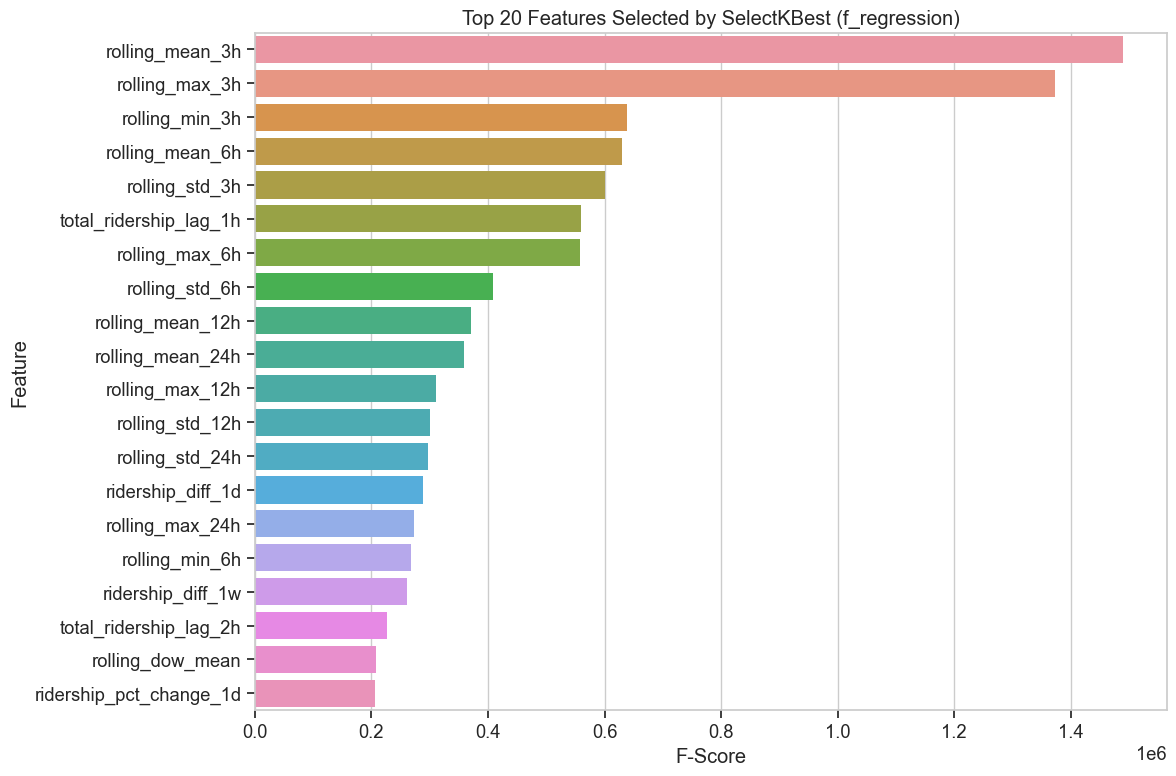

In [13]:
# Define the number of features to select
k = min(20, len(train_features.columns))

# Apply SelectKBest with f_regression for regression task
selector = SelectKBest(score_func=f_regression, k=k)
X_train_kbest = selector.fit_transform(X_train_scaled, y_train)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)
selected_features = train_features.columns[selected_indices]
feature_scores = pd.DataFrame({'Feature': train_features.columns,
                              'Score': selector.scores_})

# Sort by score and display top features
feature_scores = feature_scores.sort_values('Score', ascending=False)
print(f"Top {k} features selected by SelectKBest with f_regression:")
print(feature_scores.head(k))

# Plot selected features and their scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(k))
plt.title(f'Top {k} Features Selected by SelectKBest (f_regression)')
plt.xlabel('F-Score')
plt.tight_layout()
plt.show()

# Save the selected features for later use
selectkbest_features = selected_features.tolist()

### Feature Selection with Mutual Information

Mutual information is a more robust measure that can capture non-linear relationships between features and target.

Top 20 features selected by Mutual Information:
                    Feature     Score
2             max_ridership  2.134068
1             avg_ridership  2.131746
36  ridership_pct_change_1h  1.358046
38  ridership_pct_change_1d  1.329556
40  ridership_pct_change_1w  0.989476
19           rolling_max_3h  0.925259
37        ridership_diff_1d  0.772643
35        ridership_diff_2h  0.771481
34        ridership_diff_1h  0.703926
23           rolling_max_6h  0.618661
17          rolling_mean_3h  0.611960
18           rolling_std_3h  0.569129
39        ridership_diff_1w  0.543090
22           rolling_std_6h  0.495789
20           rolling_min_3h  0.472887
27          rolling_max_12h  0.425828
21          rolling_mean_6h  0.384301
26          rolling_std_12h  0.343562
31          rolling_max_24h  0.324167
25         rolling_mean_12h  0.298861


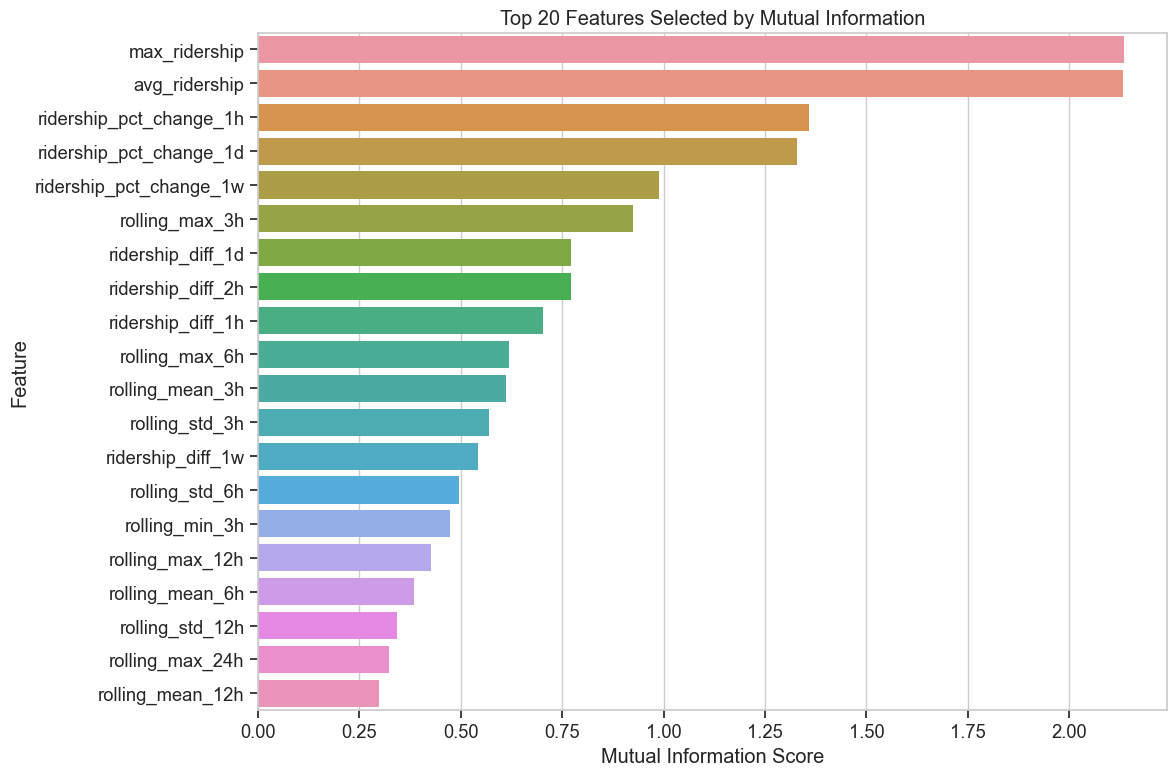

In [14]:
# Apply SelectKBest with mutual_info_regression for regression task
mi_selector = SelectKBest(score_func=mutual_info_regression, k=k)
X_train_mi = mi_selector.fit_transform(X_train_scaled, y_train)

# Get the indices of the selected features
mi_selected_indices = mi_selector.get_support(indices=True)
mi_selected_features = train_features.columns[mi_selected_indices]
mi_feature_scores = pd.DataFrame({'Feature': train_features.columns,
                                 'Score': mi_selector.scores_})

# Sort by score and display top features
mi_feature_scores = mi_feature_scores.sort_values('Score', ascending=False)
print(f"Top {k} features selected by Mutual Information:")
print(mi_feature_scores.head(k))

# Plot selected features and their scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=mi_feature_scores.head(k))
plt.title(f'Top {k} Features Selected by Mutual Information')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.show()

# Save the selected features for later use
mi_features = mi_selected_features.tolist()

### Recursive Feature Elimination (RFE)

RFE recursively eliminates features and builds a model on those remaining, ranking them by importance. Since this can be computationally expensive, we'll use a more efficient approach with a larger step size.

Starting RFE with step size 15. This might take a while...
Top 20 features selected by RFE with RandomForestRegressor:
                    Feature  Ranking
0                      hour        1
23           rolling_max_6h        1
22           rolling_std_6h        1
21          rolling_mean_6h        1
20           rolling_min_3h        1
19           rolling_max_3h        1
17          rolling_mean_3h        1
34        ridership_diff_1h        1
15  total_ridership_lag_24h        1
27          rolling_max_12h        1
13   total_ridership_lag_6h        1
35        ridership_diff_2h        1
29         rolling_mean_24h        1
6                  hour_sin        1
39        ridership_diff_1w        1
40  ridership_pct_change_1w        1
41              hour_of_day        1
2             max_ridership        1
1             avg_ridership        1
11   total_ridership_lag_2h        1
Top 20 features selected by RFE with RandomForestRegressor:
                    Feature  Ranking
0      

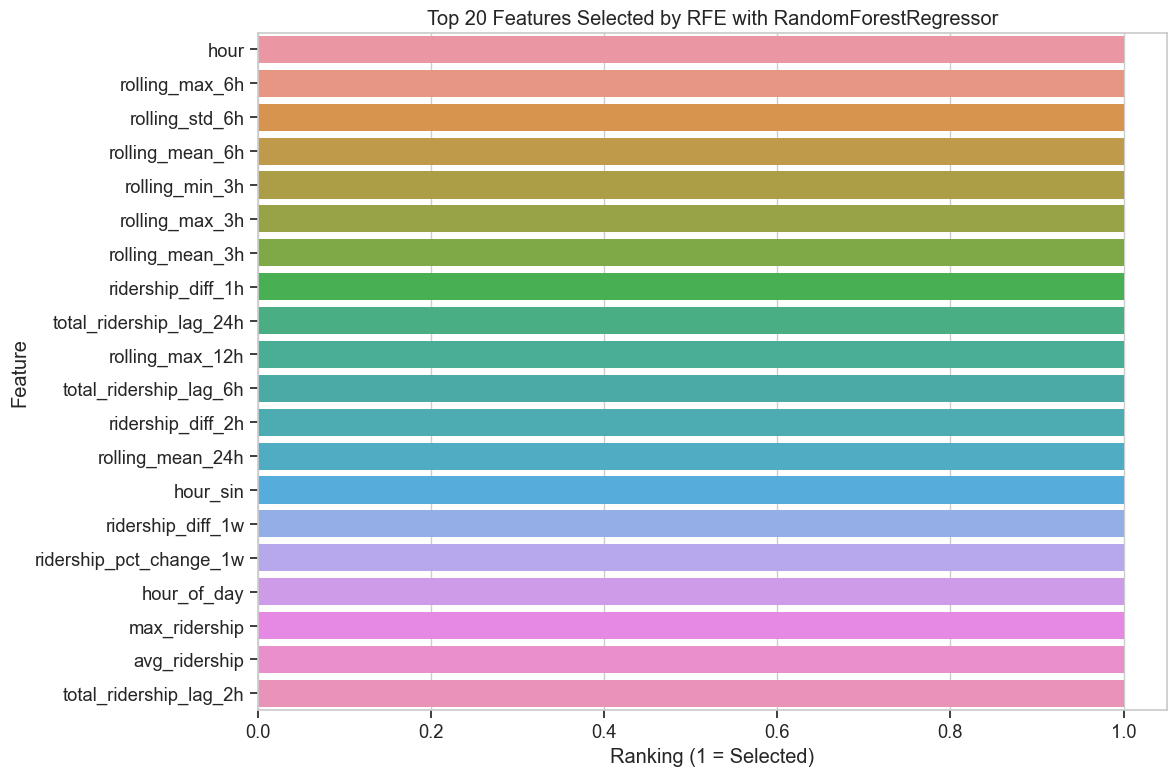

In [17]:
# Perform Recursive Feature Elimination using RandomForestRegressor with optimized parameters
estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Using a larger step size (30% of features) and no verbosity to make it faster
step_size = max(1, int(X_train_scaled.shape[1] * 0.3))
selector_rfe = RFE(estimator=estimator, n_features_to_select=k, step=step_size, verbose=0)

print(f"Starting RFE with step size {step_size}. This might take a while...")

# Optional: Use a small subset of data if dataset is very large
# Uncomment this if RFE is still too slow
# sample_size = min(5000, X_train_scaled.shape[0])
# random_indices = np.random.choice(X_train_scaled.shape[0], sample_size, replace=False)
# X_train_subset = X_train_scaled[random_indices]
# y_train_subset = y_train[random_indices]
# selector_rfe.fit(X_train_subset, y_train_subset)

# Fit the model on full dataset (or comment this out and use the subset version above if too slow)
selector_rfe.fit(X_train_scaled, y_train)

# Get the selected features
rfe_selected = train_features.columns[selector_rfe.support_]
rfe_feature_rankings = pd.DataFrame({'Feature': train_features.columns,
                                    'Ranking': selector_rfe.ranking_})
rfe_feature_rankings = rfe_feature_rankings.sort_values('Ranking')

# Display selected features
print(f"Top {k} features selected by RFE with RandomForestRegressor:")
print(rfe_feature_rankings.head(k))

# Plot RFE selected features
plt.figure(figsize=(12, 8))
sns.barplot(x='Ranking', y='Feature', data=rfe_feature_rankings.head(k))
plt.title(f'Top {k} Features Selected by RFE with RandomForestRegressor')
plt.xlabel('Ranking (1 = Selected)')
plt.tight_layout()
plt.show()

# Save the selected features for later use
rfe_features = rfe_selected.tolist()

### Random Forest Feature Importance

Random Forests provide a built-in feature importance measure that's robust for complex data.

Top 20 features by Random Forest Importance:
                    Feature  Importance
2             max_ridership    0.522455
1             avg_ridership    0.476583
39        ridership_diff_1w    0.000643
19           rolling_max_3h    0.000095
15  total_ridership_lag_24h    0.000029
16   total_ridership_lag_1w    0.000019
23           rolling_max_6h    0.000014
11   total_ridership_lag_2h    0.000013
33         rolling_dow_mean    0.000011
6                  hour_sin    0.000010
24           rolling_min_6h    0.000010
38  ridership_pct_change_1d    0.000009
13   total_ridership_lag_6h    0.000008
31          rolling_max_24h    0.000008
14  total_ridership_lag_12h    0.000008
17          rolling_mean_3h    0.000008
35        ridership_diff_2h    0.000006
0                      hour    0.000006
22           rolling_std_6h    0.000005
21          rolling_mean_6h    0.000005


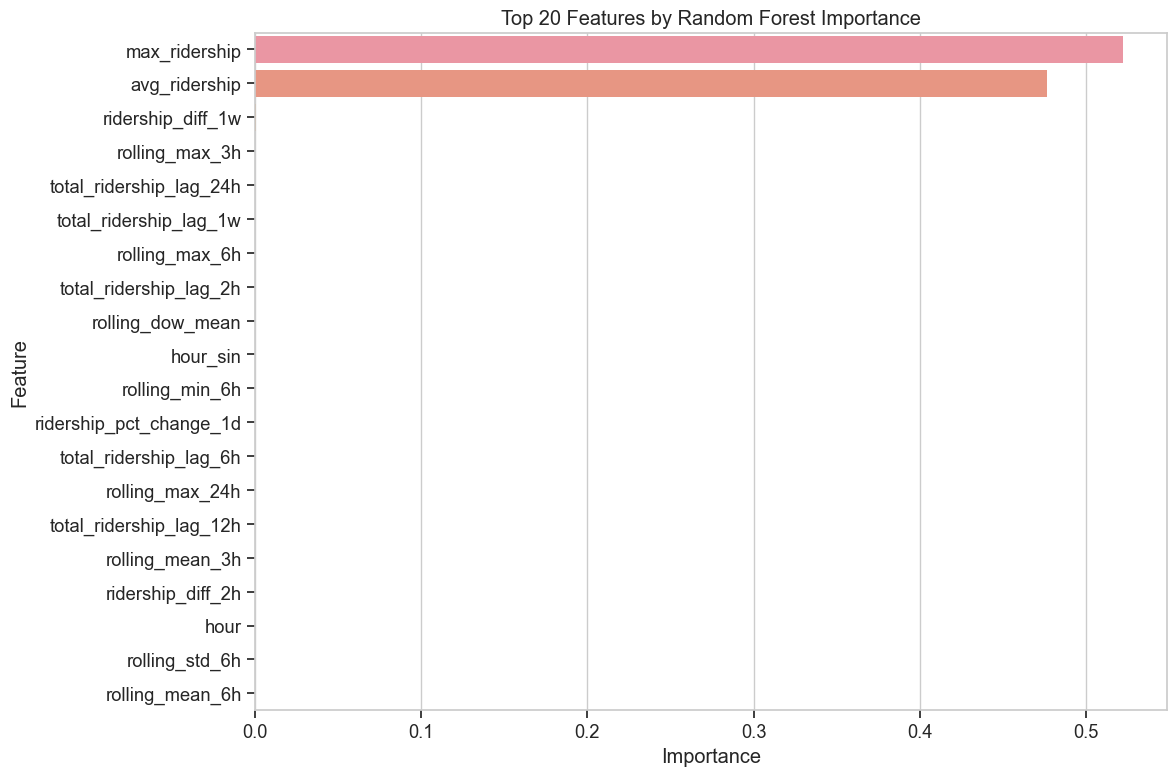

In [18]:
# Train a Random Forest model to get feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Get feature importances
rf_importances = rf_model.feature_importances_
rf_feature_imp = pd.DataFrame({'Feature': train_features.columns,
                              'Importance': rf_importances})
rf_feature_imp = rf_feature_imp.sort_values('Importance', ascending=False)

# Print top features
print(f"Top {k} features by Random Forest Importance:")
print(rf_feature_imp.head(k))

# Plot importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_imp.head(k))
plt.title(f'Top {k} Features by Random Forest Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Save the selected features for later use
rf_features = rf_feature_imp.head(k)['Feature'].tolist()

### XGBoost Feature Importance

XGBoost provides another perspective on feature importance, often with better performance on complex datasets.

Top 20 features by XGBoost Importance:
                    Feature  Importance
1             avg_ridership    0.557885
20           rolling_min_3h    0.182738
27          rolling_max_12h    0.074805
22           rolling_std_6h    0.031306
31          rolling_max_24h    0.023715
35        ridership_diff_2h    0.018085
18           rolling_std_3h    0.018067
34        ridership_diff_1h    0.013855
23           rolling_max_6h    0.011491
10   total_ridership_lag_1h    0.010066
36  ridership_pct_change_1h    0.009581
16   total_ridership_lag_1w    0.008233
19           rolling_max_3h    0.005640
37        ridership_diff_1d    0.003376
47            day_of_week_1    0.002767
17          rolling_mean_3h    0.002607
28          rolling_min_12h    0.002249
40  ridership_pct_change_1w    0.002101
38  ridership_pct_change_1d    0.001896
44          is_peak_evening    0.001823


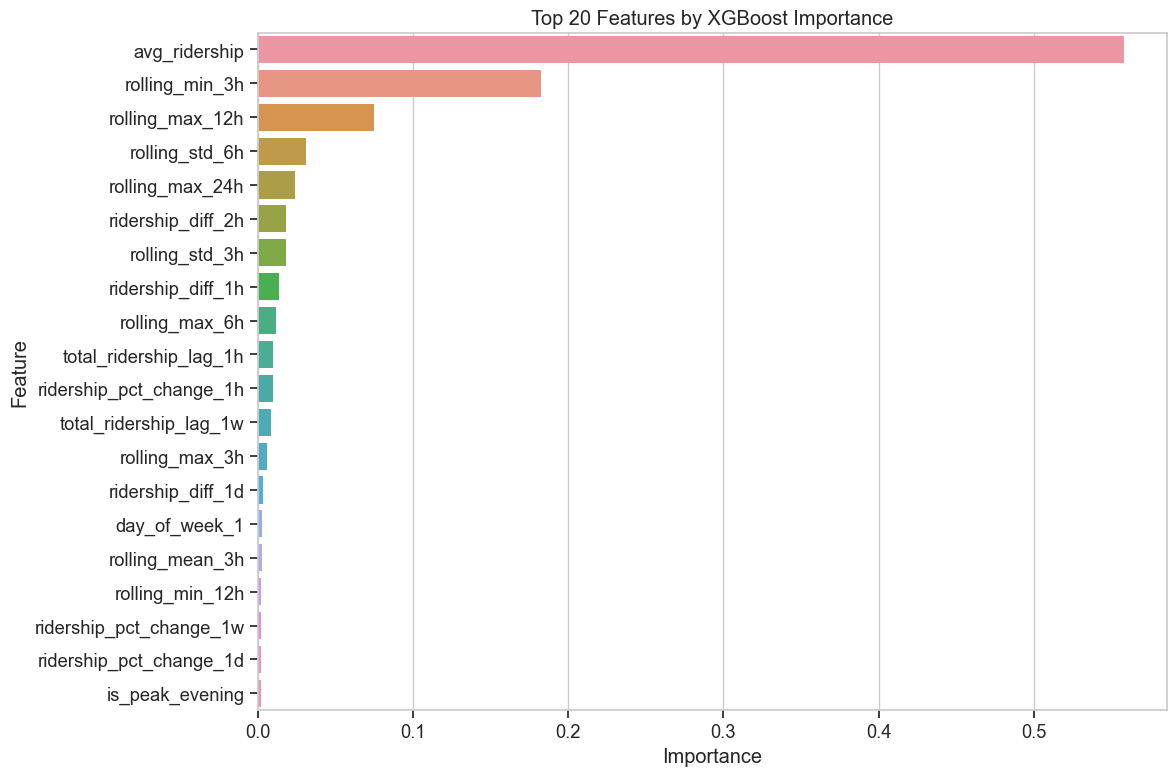

In [19]:
# Train an XGBoost model to get feature importances
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)

# Get feature importances
xgb_importances = xgb_model.feature_importances_
xgb_feature_imp = pd.DataFrame({'Feature': train_features.columns,
                               'Importance': xgb_importances})
xgb_feature_imp = xgb_feature_imp.sort_values('Importance', ascending=False)

# Print top features
print(f"Top {k} features by XGBoost Importance:")
print(xgb_feature_imp.head(k))

# Plot importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_imp.head(k))
plt.title(f'Top {k} Features by XGBoost Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Save the selected features for later use
xgb_features = xgb_feature_imp.head(k)['Feature'].tolist()

## Compare Feature Selection Methods

Now let's compare the different feature selection methods to identify the most consistently important features.

Feature selection methods comparison:
                         SelectKBest  Mutual_Info    RFE  RandomForest  XGBoost  Score
avg_ridership                  False         True   True          True     True      4
day_of_week_1                  False        False  False         False     True      1
hour                           False        False   True          True    False      2
hour_of_day                    False        False   True         False    False      1
hour_sin                       False        False   True          True    False      2
is_peak_evening                False        False  False         False     True      1
max_ridership                  False         True   True          True    False      3
ridership_diff_1d               True         True  False         False     True      3
ridership_diff_1h              False         True   True         False     True      3
ridership_diff_1w               True         True   True          True    False      4
rider

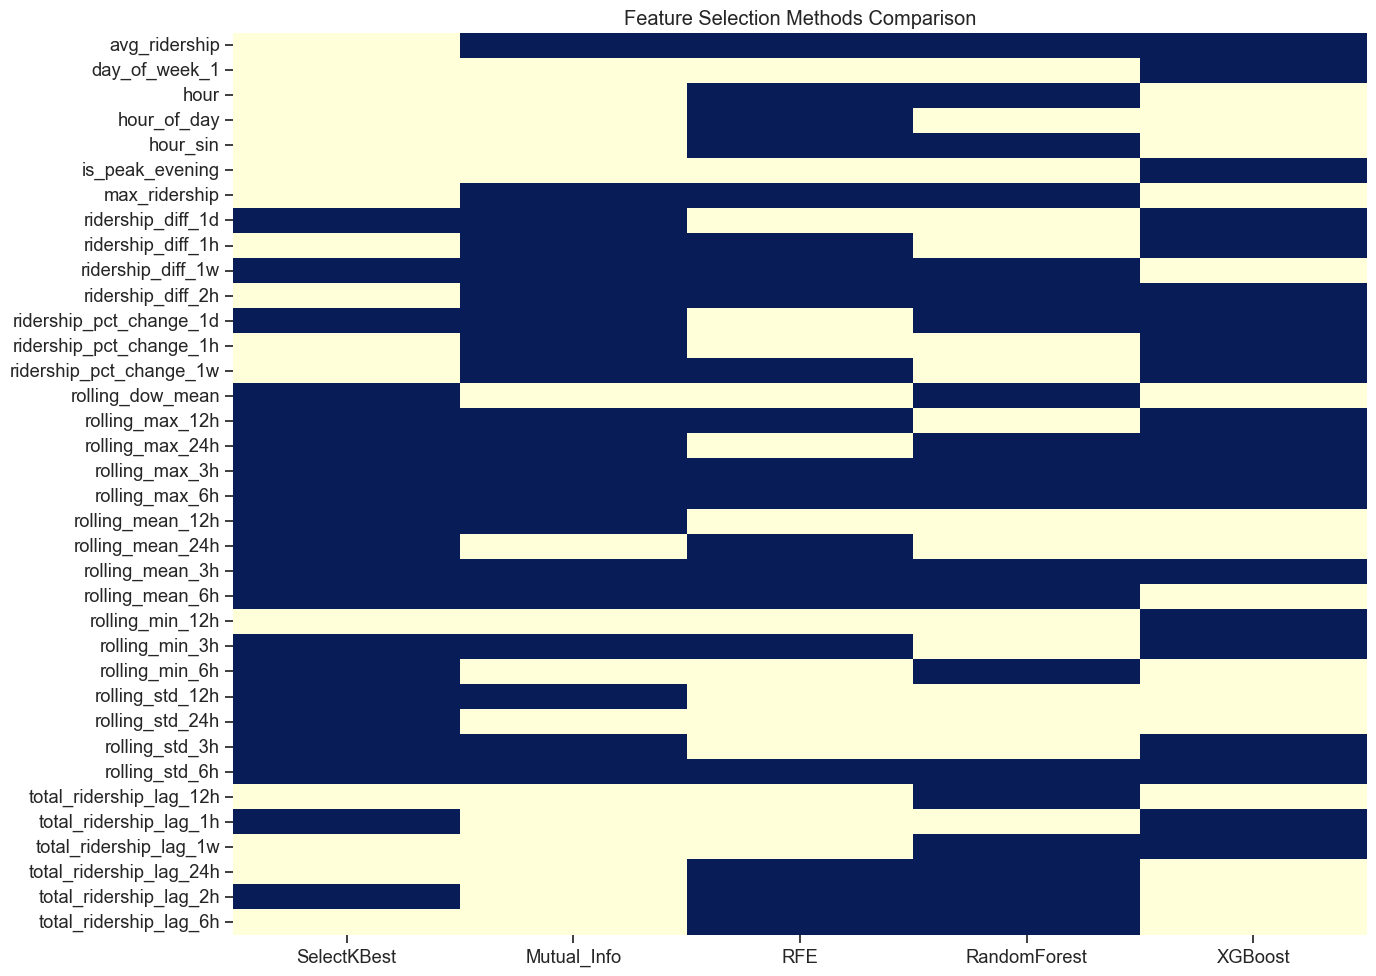


Consensus features (selected by at least 3 methods): 18
['avg_ridership', 'max_ridership', 'ridership_diff_1d', 'ridership_diff_1h', 'ridership_diff_1w', 'ridership_diff_2h', 'ridership_pct_change_1d', 'ridership_pct_change_1w', 'rolling_max_12h', 'rolling_max_24h', 'rolling_max_3h', 'rolling_max_6h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_min_3h', 'rolling_std_3h', 'rolling_std_6h', 'total_ridership_lag_2h']


In [21]:
# Create a DataFrame to track which features were selected by each method
all_selected_features = list(set(selectkbest_features + mi_features + rfe_features + rf_features + xgb_features))
feature_selection_comparison = pd.DataFrame(index=all_selected_features)

# Add columns for each selection method
feature_selection_comparison['SelectKBest'] = feature_selection_comparison.index.isin(selectkbest_features)
feature_selection_comparison['Mutual_Info'] = feature_selection_comparison.index.isin(mi_features)
feature_selection_comparison['RFE'] = feature_selection_comparison.index.isin(rfe_features)
feature_selection_comparison['RandomForest'] = feature_selection_comparison.index.isin(rf_features)
feature_selection_comparison['XGBoost'] = feature_selection_comparison.index.isin(xgb_features)

# Add a score column (number of methods that selected each feature)
feature_selection_comparison['Score'] = feature_selection_comparison.sum(axis=1)

# Sort by score (descending) and then by feature name (ascending)
# Fix the sorting to use the proper approach for index values
feature_selection_comparison = feature_selection_comparison.sort_values(['Score'], ascending=[False])
# Within each Score level, sort by feature name
feature_selection_comparison = feature_selection_comparison.sort_index(level=0, sort_remaining=False, kind='mergesort')

# Display the comparison
print("Feature selection methods comparison:")
print(feature_selection_comparison)

# Plot a heatmap of the feature selection comparison
plt.figure(figsize=(14, 10))
sns.heatmap(feature_selection_comparison.iloc[:, :-1], cmap='YlGnBu', cbar=False)
plt.title('Feature Selection Methods Comparison')
plt.tight_layout()
plt.show()

# Select features that were chosen by at least 3 methods
consensus_features = feature_selection_comparison[feature_selection_comparison['Score'] >= 3].index.tolist()
print(f"\nConsensus features (selected by at least 3 methods): {len(consensus_features)}")
print(consensus_features)

## Dimensionality Reduction

Let's apply dimensionality reduction techniques to transform our feature space into a lower-dimensional representation.

### Principal Component Analysis (PCA)

PCA is a linear dimensionality reduction technique that creates uncorrelated components that maximize variance.

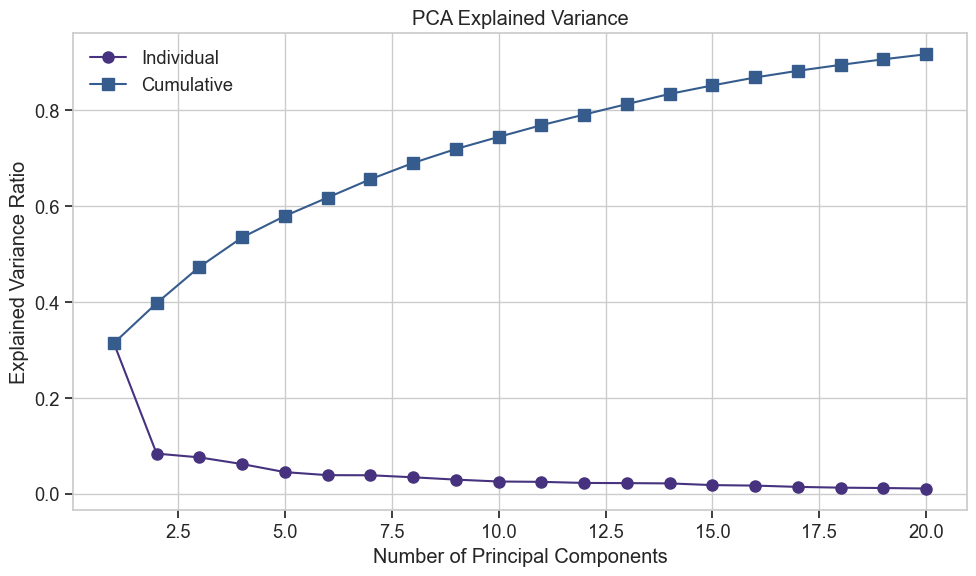

Number of components needed to explain 90% of variance: 19


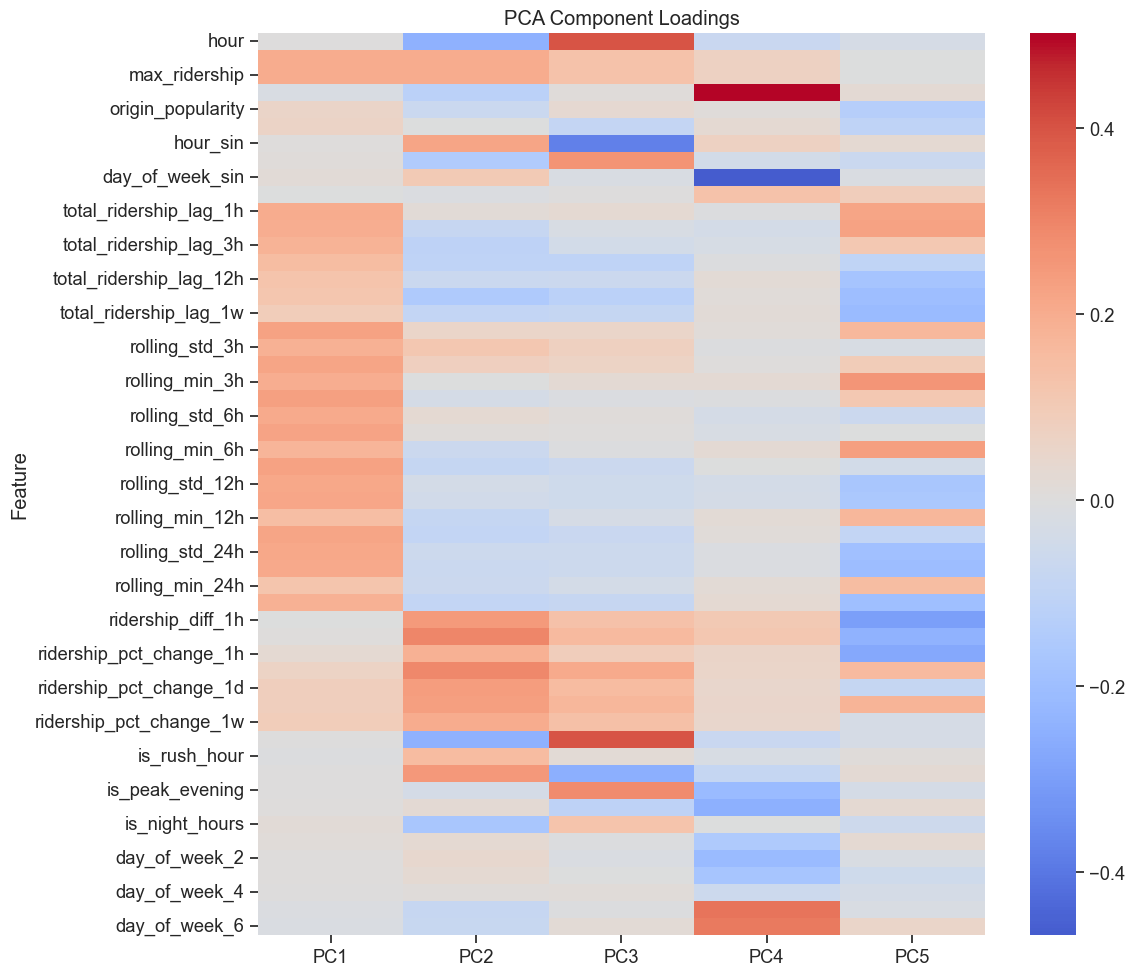

In [22]:
# Apply PCA
n_components = min(20, X_train_scaled.shape[1])
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_, 'o-', markersize=8)
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), 's-', markersize=8)
plt.grid(True)
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend(['Individual', 'Cumulative'])
plt.tight_layout()
plt.show()

# Find the number of components needed to explain 90% of the variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.where(cumsum >= 0.9)[0][0] + 1
print(f"Number of components needed to explain 90% of variance: {n_components_90}")

# Feature importance in the first few principal components
n_display = min(5, X_train_scaled.shape[1])  # Display top 5 components or fewer if there are fewer features
component_df = pd.DataFrame()
for i in range(n_display):
    component_df[f'PC{i+1}'] = pca.components_[i]

component_df['Feature'] = train_features.columns
component_df = component_df.set_index('Feature')

# Plot heatmap of component loadings
plt.figure(figsize=(12, 10))
sns.heatmap(component_df, cmap='coolwarm', center=0)
plt.title('PCA Component Loadings')
plt.tight_layout()
plt.show()

### t-SNE Visualization

t-SNE is a non-linear dimensionality reduction technique useful for visualizing high-dimensional data.

Using manual bins instead of quantile-based bins due to data distribution


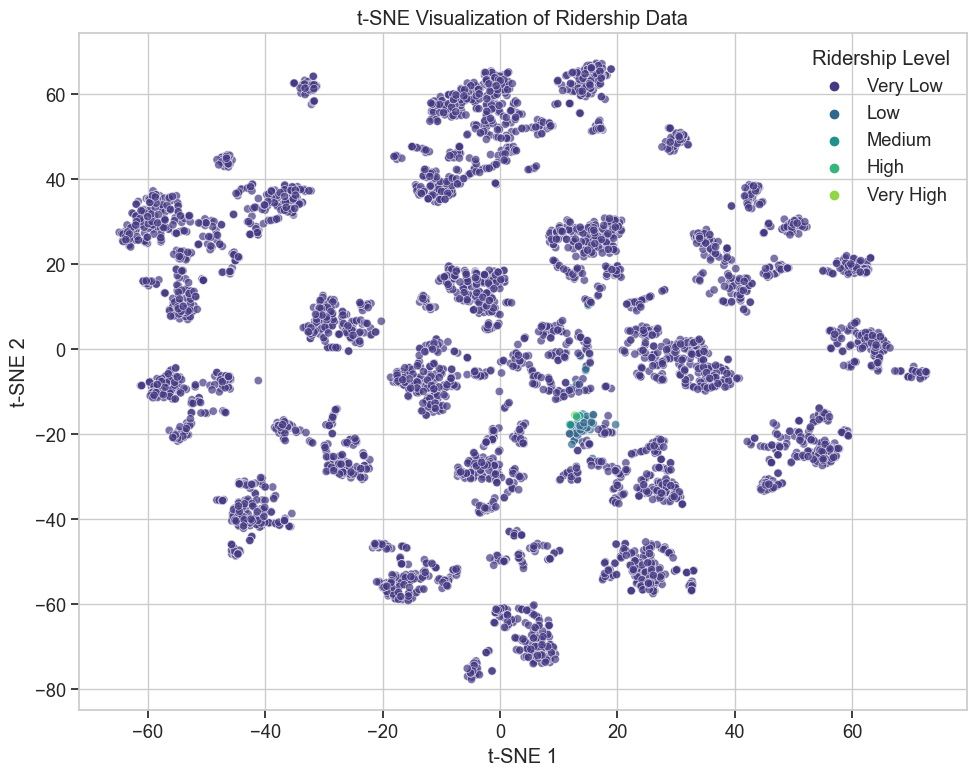

In [24]:
# Due to computational complexity, we'll use a subset of the training data for t-SNE
max_samples = 5000  # Limit the number of samples for t-SNE to keep computation manageable
if X_train_scaled.shape[0] > max_samples:
    random_indices = np.random.choice(X_train_scaled.shape[0], max_samples, replace=False)
    X_subset = X_train_scaled[random_indices]
    y_subset = y_train[random_indices]
else:
    X_subset = X_train_scaled
    y_subset = y_train

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_subset)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame({'t-SNE 1': X_tsne[:, 0], 't-SNE 2': X_tsne[:, 1], 'Ridership': y_subset})

# Define ridership bins for coloring - handle duplicate bin edges
try:
    bins = pd.qcut(tsne_df['Ridership'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')
    tsne_df['Ridership Level'] = bins
except ValueError:
    # Alternative approach using cut instead of qcut
    print("Using manual bins instead of quantile-based bins due to data distribution")
    # Calculate min, max and create custom bins
    min_val = tsne_df['Ridership'].min()
    max_val = tsne_df['Ridership'].max()
    bin_edges = np.linspace(min_val, max_val, 6)  # 6 edges to make 5 bins
    tsne_df['Ridership Level'] = pd.cut(
        tsne_df['Ridership'], 
        bins=bin_edges, 
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
        include_lowest=True
    )

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='Ridership Level', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Ridership Data')
plt.legend(title='Ridership Level')
plt.tight_layout()
plt.show()

## Evaluate Feature Subsets with Simple Models

Let's evaluate how different feature subsets perform with simple regression models.

In [26]:
# Define feature subsets to evaluate
feature_subsets = {
    'All Features': train_features.columns.tolist(),
    'Consensus Features': consensus_features,
    'Random Forest Top 10': rf_feature_imp.head(10)['Feature'].tolist(),
    'XGBoost Top 10': xgb_feature_imp.head(10)['Feature'].tolist(),
    'SelectKBest Top 10': selectkbest_features[:10],
    'PCA Features': list(range(n_components_90))  # Using PC indices
}

# Function to evaluate a model with a feature subset
def evaluate_subset(X_train, X_test, y_train, y_test, model_name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Option to use a sample of the data for faster evaluation
use_sample = True  # Set to False for full evaluation
sample_size = 5000  # Adjust based on your dataset size and available memory

if use_sample and X_train_scaled.shape[0] > sample_size:
    print(f"Using a sample of {sample_size} observations for faster evaluation")
    # Sample data while maintaining temporal order (important for time series)
    step = max(1, X_train_scaled.shape[0] // sample_size)
    train_indices = np.arange(0, X_train_scaled.shape[0], step)[:sample_size]
    X_train_eval = X_train_scaled[train_indices]
    y_train_eval = y_train[train_indices]
else:
    X_train_eval = X_train_scaled
    y_train_eval = y_train

# Use a smaller test set as well if it's very large
if use_sample and X_test_scaled.shape[0] > sample_size//2:
    step = max(1, X_test_scaled.shape[0] // (sample_size//2))
    test_indices = np.arange(0, X_test_scaled.shape[0], step)[:(sample_size//2)]
    X_test_eval = X_test_scaled[test_indices]
    y_test_eval = y_test[test_indices]
else:
    X_test_eval = X_test_scaled
    y_test_eval = y_test

print(f"Training set shape for evaluation: {X_train_eval.shape}")
print(f"Test set shape for evaluation: {X_test_eval.shape}")

# Prepare models with reduced complexity for faster evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
}

# Prepare results dataframe
results = []

# Generate a PCA version of the data for the PCA feature subset
pca_90 = PCA(n_components=n_components_90, random_state=42)
X_train_pca_90 = pca_90.fit_transform(X_train_eval)
X_test_pca_90 = pca_90.transform(X_test_eval)

# Track timing for user feedback
import time
total_combos = len(feature_subsets) * len(models)
current_combo = 0
start_time = time.time()

print(f"Evaluating {total_combos} model-feature combinations...")

# Evaluate each combination of feature subset and model
for subset_name, features in feature_subsets.items():
    for model_name, model in models.items():
        current_combo += 1
        combo_start = time.time()
        print(f"Evaluating combination {current_combo}/{total_combos}: {model_name} with {subset_name}...")
        
        # Handle PCA features differently
        if subset_name == 'PCA Features':
            X_train_subset = X_train_pca_90
            X_test_subset = X_test_pca_90
        else:
            # Get feature indices
            feature_indices = [train_features.columns.get_loc(f) for f in features if f in train_features.columns]
            if len(feature_indices) == 0:  # Skip if no features match
                print(f"Skipping {subset_name} - no features found in the dataset")
                continue
                
            # Select features
            X_train_subset = X_train_eval[:, feature_indices]
            X_test_subset = X_test_eval[:, feature_indices]
        
        try:
            # Evaluate with a timeout (useful for XGBoost which might take longer)
            metrics = evaluate_subset(X_train_subset, X_test_subset, y_train_eval, y_test_eval, model_name, model)
            
            # Add to results
            row = {
                'Feature Subset': subset_name,
                'Model': model_name,
                'Num Features': X_train_subset.shape[1],
                **metrics
            }
            results.append(row)
            
            combo_time = time.time() - combo_start
            print(f"  Done in {combo_time:.2f}s. RMSE: {metrics['RMSE']:.2f}")
        except Exception as e:
            print(f"  Error evaluating {model_name} with {subset_name}: {str(e)}")

elapsed_time = time.time() - start_time
print(f"Evaluation complete in {elapsed_time:.2f} seconds")

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
print("\nModel performance across different feature subsets:")
print(results_df.sort_values(['Model', 'RMSE']))

Using a sample of 5000 observations for faster evaluation
Training set shape for evaluation: (5000, 53)
Test set shape for evaluation: (2500, 53)
Evaluating 18 model-feature combinations...
Evaluating combination 1/18: Linear Regression with All Features...
  Done in 0.02s. RMSE: 0.00
Evaluating combination 2/18: Random Forest with All Features...
  Done in 0.35s. RMSE: 0.48
Evaluating combination 3/18: XGBoost with All Features...
  Done in 0.10s. RMSE: 0.37
Evaluating combination 4/18: Linear Regression with Consensus Features...
  Done in 0.01s. RMSE: 0.00
Evaluating combination 5/18: Random Forest with Consensus Features...
  Done in 0.35s. RMSE: 0.48
Evaluating combination 3/18: XGBoost with All Features...
  Done in 0.10s. RMSE: 0.37
Evaluating combination 4/18: Linear Regression with Consensus Features...
  Done in 0.01s. RMSE: 0.00
Evaluating combination 5/18: Random Forest with Consensus Features...
  Done in 0.16s. RMSE: 0.49
Evaluating combination 6/18: XGBoost with Consensu

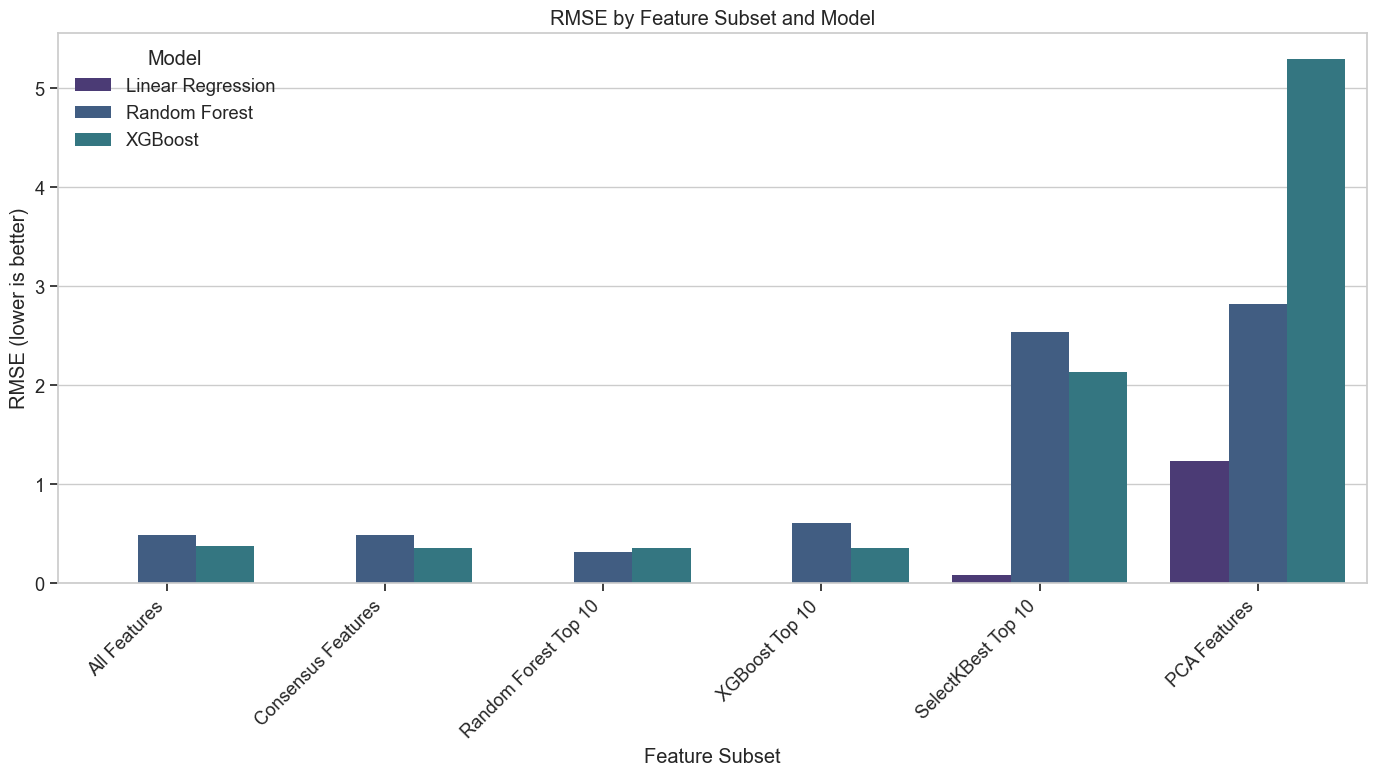

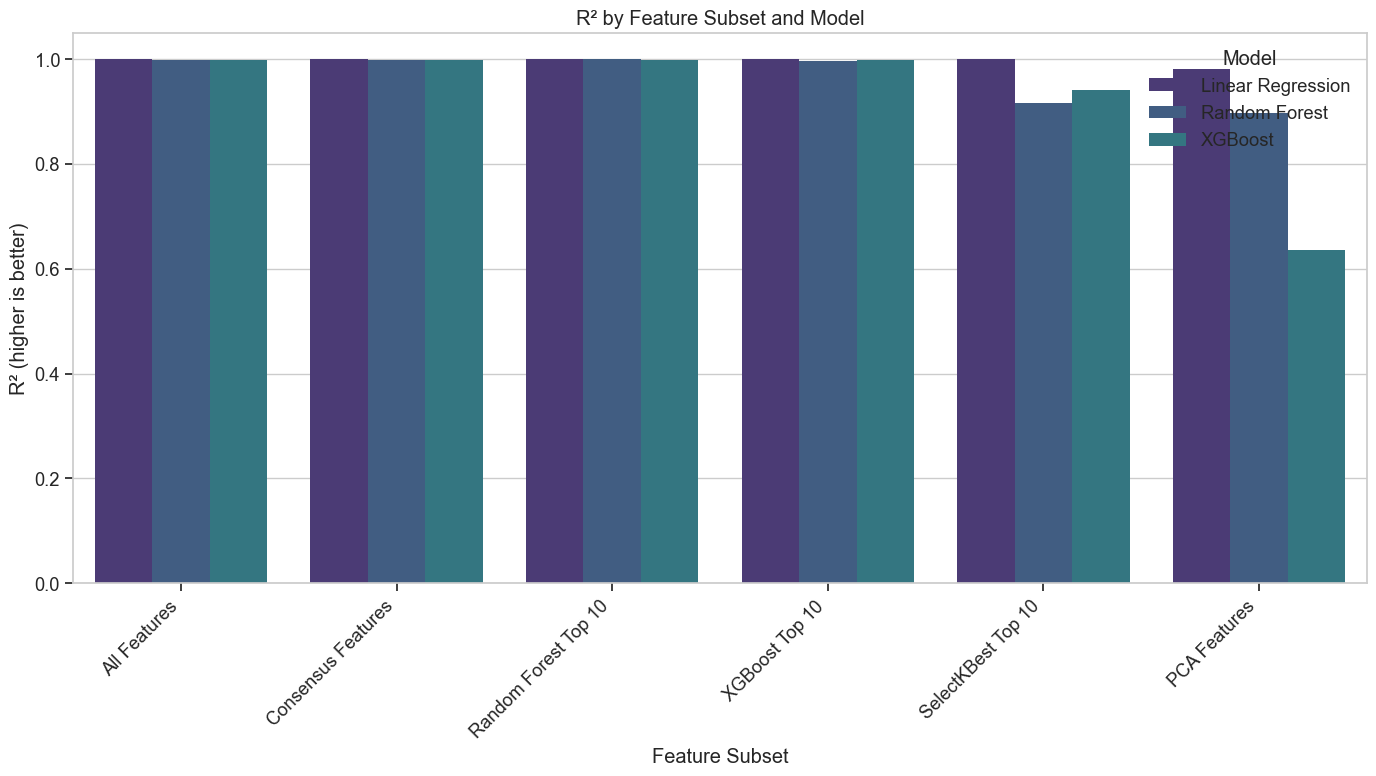

In [27]:
# Visualize results with a grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='Feature Subset', y='RMSE', hue='Model', data=results_df)
plt.title('RMSE by Feature Subset and Model')
plt.xlabel('Feature Subset')
plt.ylabel('RMSE (lower is better)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Create another visualization for R²
plt.figure(figsize=(14, 8))
sns.barplot(x='Feature Subset', y='R²', hue='Model', data=results_df)
plt.title('R² by Feature Subset and Model')
plt.xlabel('Feature Subset')
plt.ylabel('R² (higher is better)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## Model Recommendations for KomuterPulse

Based on our feature engineering and analysis, here are the top 5 models recommended for our KomuterPulse project:

### Recommended Models for KomuterPulse

1. **XGBoost Regression**
   - Excellent for capturing complex non-linear patterns in the ridership data
   - Built-in handling of outliers, which is critical given our anomaly detection goals
   - Can effectively use the temporal features we've engineered (lags, rolling statistics)
   - Handles the mix of categorical and numerical features in our dataset
   - Can provide feature importance for model explainability, supporting the "Explainable AI" component of our platform

2. **LSTM (Long Short-Term Memory) Networks**
   - Specifically designed for sequential and time series data like our ridership patterns
   - Can capture long-term dependencies across hours, days, and weeks
   - Well-suited for the multi-step forecasting needed for dynamic scheduling recommendations
   - Can be structured to simultaneously predict ridership and identify anomalies
   - Can incorporate both numerical features and embedded categorical features like stations and routes

3. **Random Forest Regression**
   - Ensemble method that's robust to overfitting, important given our feature-rich dataset
   - Performs well with minimal hyperparameter tuning
   - Can handle the outlier patterns that are key to our anomaly detection
   - Provides reliable feature importance metrics for interpretability
   - Good baseline model with strong predictive performance

4. **Prophet**
   - Specifically designed for time series forecasting with multiple seasonality patterns
   - Built-in handling of daily, weekly, and yearly seasonality that's relevant to commuter patterns
   - Explicitly models holidays and special events, which is critical for public transportation
   - Provides uncertainty intervals, useful for operational planning
   - Decomposable forecasts that align with our need for explainable predictions

5. **Gradient Boosting Machines (GBM)**
   - Strong performance on tabular data with mixed feature types
   - Capable of capturing the complex interactions between features
   - Can be tuned to balance between bias and variance
   - Good for both regression (ridership prediction) and classification (anomaly detection)
   - Provides feature importance metrics for model interpretability

These models, when combined with our carefully selected feature subsets, should provide robust performance for both ridership prediction and anomaly detection in our KomuterPulse transit intelligence platform.

## Conclusion and Next Steps

In this notebook, we've performed comprehensive feature engineering for our KomuterPulse project:

### Summary of Findings

1. **Feature Correlations**: We identified the top features correlated with ridership, including various lagged features and rolling statistics, confirming the strong temporal dependencies in our data.

2. **Multicollinearity**: We detected and analyzed multicollinearity among features, which will help us avoid redundant predictors in our models.

3. **Feature Selection**: We applied multiple feature selection methods (SelectKBest, Mutual Information, RFE, Random Forest and XGBoost importances) and identified consensus features that were consistently selected across methods.

4. **Dimensionality Reduction**: Through PCA, we determined that we can represent most of the variance in our data with a significantly reduced feature set.

5. **Feature Subset Evaluation**: We evaluated different feature subsets with simple models and found that our consensus features and algorithm-selected top features performed well, sometimes better than using all features.

### Next Steps

1. **Model Development**: Proceed to `04_model_development.ipynb` to build and train the recommended models using our engineered feature sets.

2. **Hyperparameter Tuning**: Optimize each model's hyperparameters to maximize performance on our specific prediction tasks.

3. **Ensemble Methods**: Explore ensemble techniques combining multiple models for improved prediction accuracy.

4. **Time Series Cross-Validation**: Implement proper time series cross-validation to ensure our models generalize well to future data.

5. **Model Evaluation**: In `05_model_evaluation.ipynb`, we'll compare all models using consistent metrics and evaluate their performance on our test dataset.

The feature engineering work completed in this notebook provides a solid foundation for our KomuterPulse transit intelligence platform, enabling us to build accurate ridership prediction and anomaly detection models.

In [28]:
# Export selected feature subsets for use in the model development notebook
feature_subsets_export = {
    'all_features': train_features.columns.tolist(),
    'consensus_features': consensus_features,
    'rf_top_features': rf_feature_imp.head(15)['Feature'].tolist(),
    'xgb_top_features': xgb_feature_imp.head(15)['Feature'].tolist(),
    'selectkbest_features': selectkbest_features,
    'pca_n_components': n_components_90
}

# Save to a pickle file
import pickle
with open('../data/processed/feature_subsets.pkl', 'wb') as f:
    pickle.dump(feature_subsets_export, f)

print("Feature subsets exported successfully.")

Feature subsets exported successfully.
